In [1]:
import pandas as pd
import spacy
import json
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertForTokenClassification, AdamW
nlp = spacy.load('en_core_web_sm')


In [2]:
path_to_file = "../data/labeled_data_1000rows.csv"
# path_to_file = "../data/labeled_data_1000rows_bal.csv"
df = pd.read_csv(path_to_file, encoding='utf8', sep='|', nrows=628, header=1, names=['text', 'entities'])
df.astype('string')
df = df.fillna('')

df['entities'] = df['entities'].replace('restaurants', '')

df['entities'] = df['entities'].apply(lambda x: x.split(',')[0])
df['nlp'] = df['text'].apply(nlp)


In [3]:
df['biluo'] = df['nlp'].apply(lambda x: [i.ent_iob_ for i in x])
df.head()


MAX_LEN = 75
bs = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)


def create_tokens_with_labels(sen, lebels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sen, lebels):
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)
        tokenized_sentence.extend(tokenized_word)
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

tag_values = ['B', 'I', 'O', 'PAD']
tag2idx = {t: i for i, t in enumerate(tag_values)}


tokens_with_labels = [
    create_tokens_with_labels(sent, labs)
    for sent, labs
    in zip([[token.text for token in sen] for sen in df['nlp']], list(df['biluo']))
]



tokenized_texts = [token_label_pair[0] for token_label_pair in tokens_with_labels]
labels = [token_label_pair[1] for token_label_pair in tokens_with_labels]


input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")


tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")


attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]


tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=1234, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=1234, test_size=0.2)


tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)


train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [4]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=2e-5,
    eps=1e-8
)

In [5]:
from transformers import get_linear_schedule_with_warmup
epochs = 3
max_grad_norm = 1.0
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [6]:
accuracy, precision, recall, f1_score, iterations, loss = [], [], [], [], [], []
from tqdm import trange
from seqeval.metrics import f1_score, accuracy_score, recall_score, precision_score
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    model.train()
    total_loss = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_labels = b_labels.type(torch.LongTensor)
        b_input_ids = b_input_ids.type(torch.LongTensor)
        model.zero_grad()
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        loss.backward()
        total_loss += loss.item()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        scheduler.step()
    avg_train_loss = total_loss / len(train_dataloader)
    print("t_loss: {}".format(avg_train_loss))
    loss_values.append(avg_train_loss)
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        b_labels = b_labels.type(torch.LongTensor)
        b_input_ids = b_input_ids.type(torch.LongTensor)
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("v_loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]

    pred_tags = [x.replace('I', 'B') for x in pred_tags]
    valid_tags = [x.replace('I', 'B') for x in valid_tags]
    a = accuracy_score(pred_tags, valid_tags)
    print("Validation Accuracy: {}".format(a))
    accuracy.append(a)
    r = recall_score([pred_tags], [valid_tags])
    print("Validation Recall: {}".format(r))
    recall.append(r)
    p = precision_score([pred_tags], [valid_tags])
    print("Validation Precision: {}".format(p))
    precision.append(p)
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]g:\magisterka\automated-web-data-discovery-feature-basic_scraper\venv\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: PAD seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch: 100%|██████████| 3/3 [08:19<00:00, 166.38s/it]


Average train loss: 0.5206034537404776
Validation loss: 0.3639049530029297
Validation Accuracy: 0.8810361368724017
Validation Recall: 0.8
Validation Precision: 0.021108179419525065
Validation F1-Score: 0.04113110539845758
Average train loss: 0.3005921244621277
Validation loss: 0.29854944348335266
Validation Accuracy: 0.9040614007035497
Validation Recall: 0.6652542372881356
Validation Precision: 0.41424802110817943
Validation F1-Score: 0.510569105691057
Average train loss: 0.2447811271995306
Validation loss: 0.2743779942393303
Validation Accuracy: 0.9146146466261592
Validation Recall: 0.6989247311827957
Validation Precision: 0.5145118733509235
Validation F1-Score: 0.5927051671732523


In [55]:
print(valid_tags)


['O', 'O', 'O', 'O', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'B', 'B', 'O', 'O', 'B', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'B', 'I', 'I', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'B', 'B', 'I', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

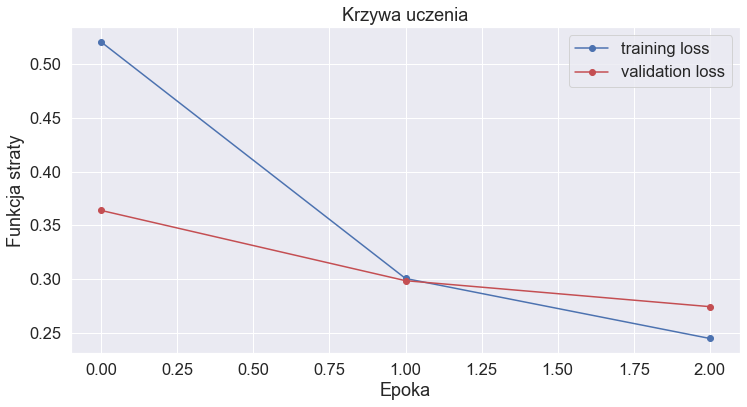

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

plt.title("Krzywa uczenia")
plt.xlabel("Epoka")
plt.ylabel("Funkcja straty")
plt.legend()

plt.savefig('../plots/bert_01_learning_curve_3_epoch_v2.png')


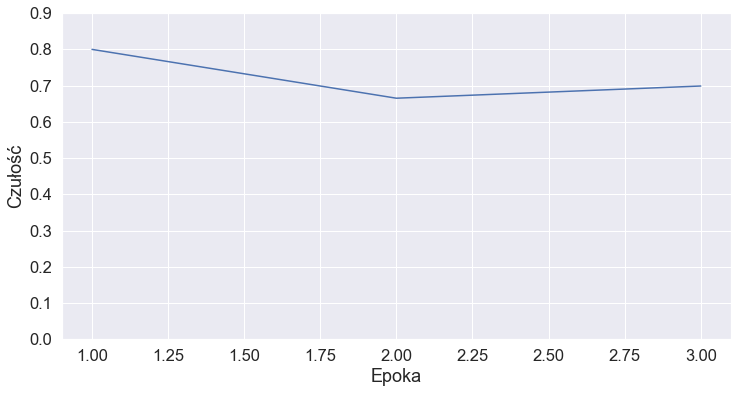

In [12]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='darkgrid')

sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)
plt.ylim(0.0, 0.9)
data_plot = pd.DataFrame({"Epoka": [1, 2, 3],
                          "Dokładność":accuracy,
                          "Precyzja":precision,
                          "Czułość":recall
                          })
sns.lineplot(x='Epoka', y='Czułość', data=data_plot)
plt.savefig('../plots/bert_ner_recall_v2.png')


In [ ]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          filename=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.
    filename:      Filename.
    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

    if filename:
        plt.savefig(filename)

    return accuracy, precision, recall, f1_score